# Early Identification of Underperforming Students



## Main Imports

In [67]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.graphics.mosaicplot import mosaic

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import resample, shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load the data

In [ ]:
main_path = '/content/drive/My Drive/University Work/Year 4/Learning Analytics/'

studentAssessment = pd.read_csv(main_path + 'data/studentAssessment.csv')
studentVle1 = pd.read_csv(main_path + 'data/studentVle.csv', engine='python')
studentVle2 = pd.read_csv(main_path + 'data/studentVle.csv')
vle = pd.read_csv(main_path + 'data/vle.csv')
studentRegistration = pd.read_csv(main_path + 'data/studentRegistration.csv')
courses = pd.read_csv(main_path + 'data/courses.csv')
studentInfo = pd.read_csv(main_path + 'data/studentInfo.csv')
assessments = pd.read_csv(main_path + 'data/assessments.csv')

## Use registration info (date signed up), demographic, stuff from this
#https://dl.acm.org/doi/pdf/10.1145/3027385.3027449

## Descriptive Analytics

### Plot the distribution of final results

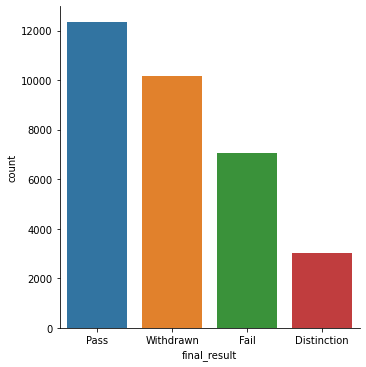

In [ ]:
sns.catplot(x="final_result", data=studentInfo, kind="count", height=5)

### Plot distribution after condensing data into Pass (Pass + Distinction) or Fail

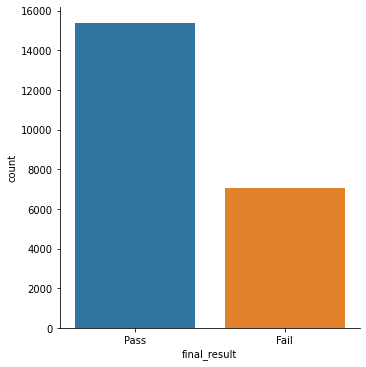

In [ ]:
pass_fail_info = studentInfo[studentInfo['final_result'] != 'Withdrawn']
labels = {
    'Pass': 'Pass',
    'Fail': 'Fail',
    'Distinction': 'Pass'
}
pass_fail_info['final_result'] = pass_fail_info['final_result'].map(labels)
sns.catplot(x="final_result", data=pass_fail_info, kind="count", height=5)

### Plot the correlation between level of education and number of credits taken

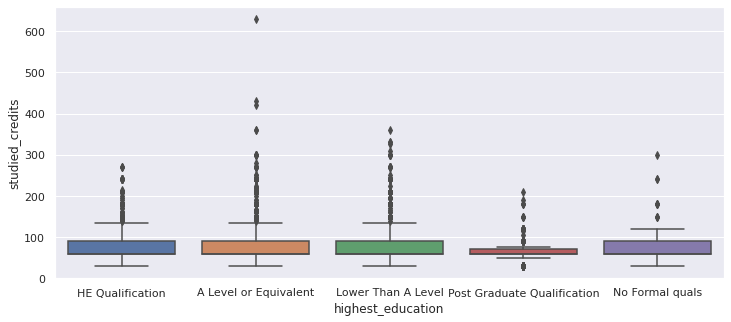

In [ ]:
sns.set(rc={'figure.figsize':(12, 5)})
sns.boxplot(x = 'highest_education', y = 'studied_credits', data=pass_fail_info)

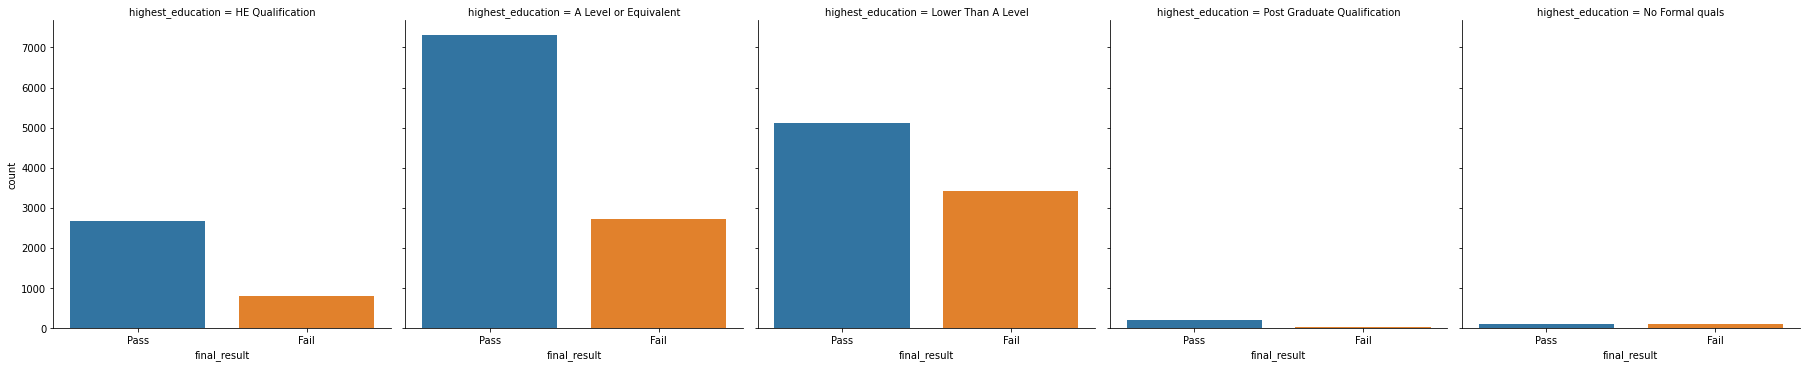

In [ ]:
sns.catplot(x="final_result", col="highest_education", data=pass_fail_info, kind="count", height=5)

### Plot the correlation between region and IMD band

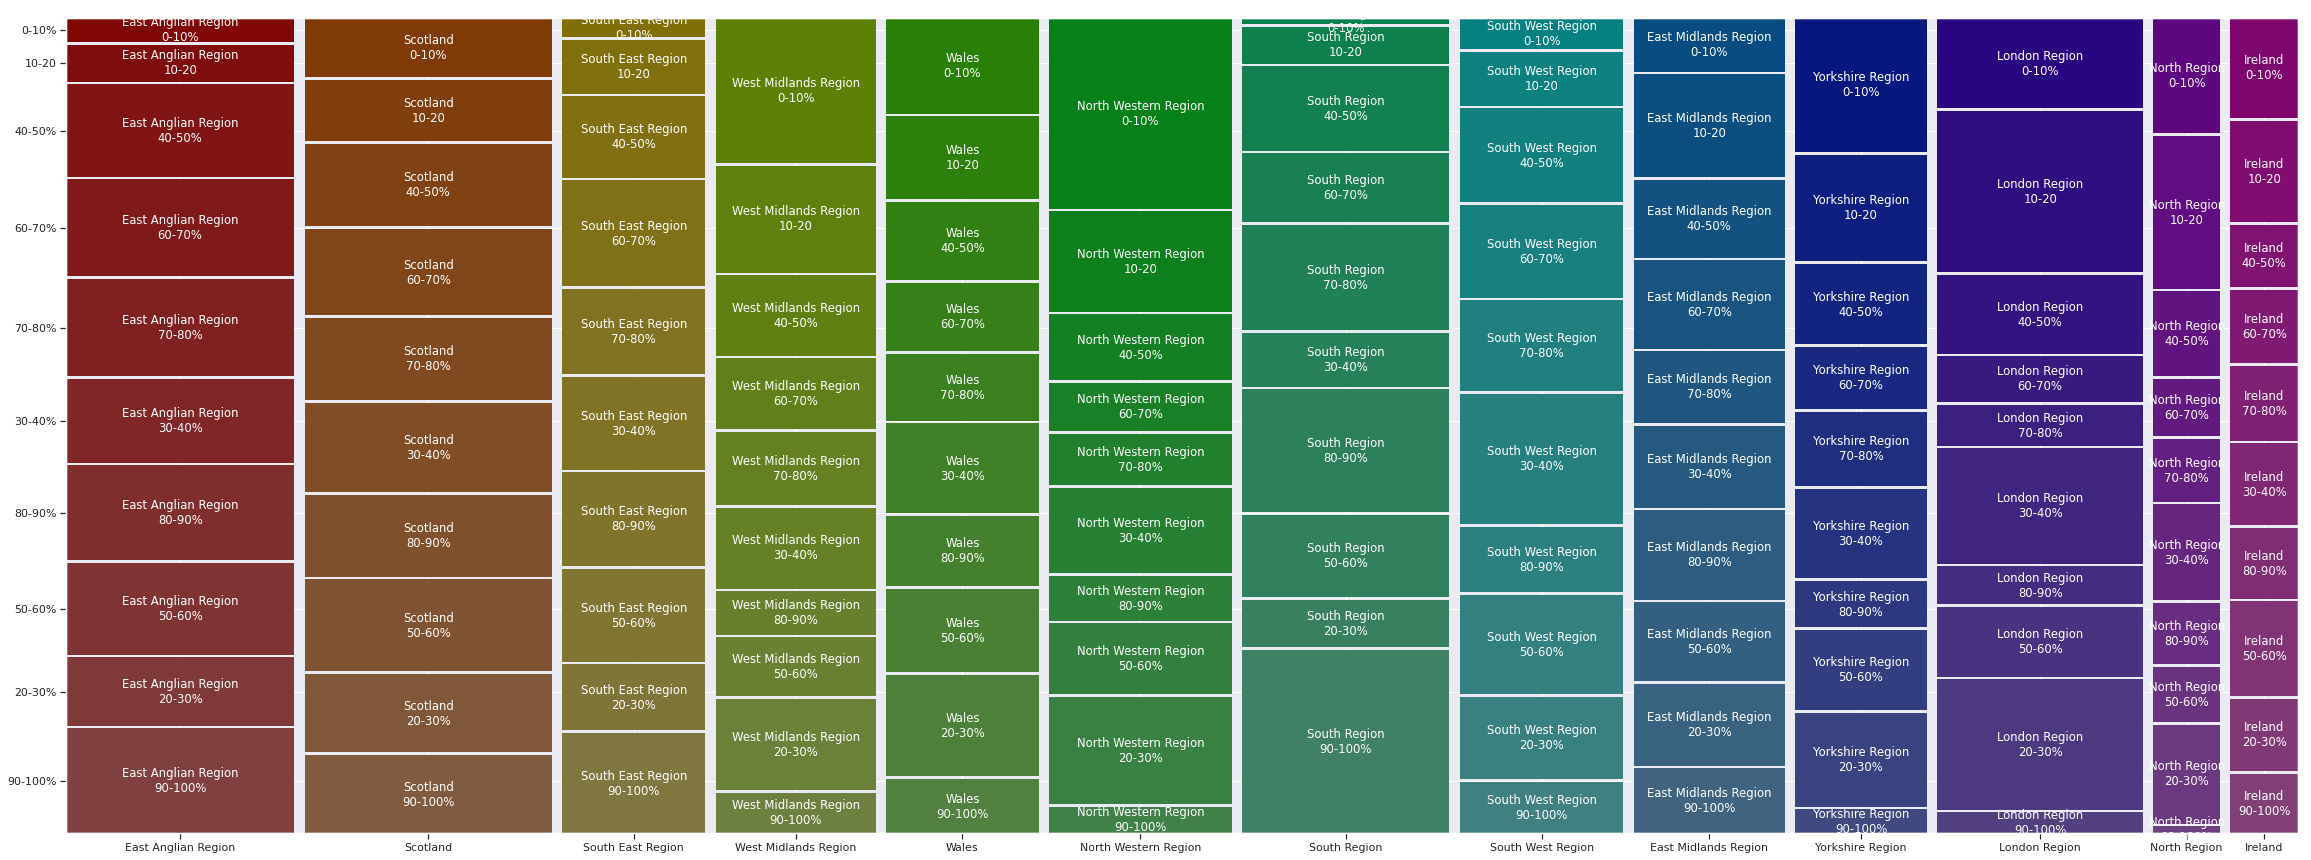

In [ ]:
plt.rcParams["figure.figsize"] = (40, 15)
plt.rcParams['font.size'] = 14.0
plt.rcParams['text.color'] = 'white'
mosaic(pass_fail_info, ['region', 'imd_band']);

### Merge the dataframes to have number of clicks and result in same df

In [ ]:
merged_df = pd.merge(pass_fail_info, studentVle1, on=['id_student', 'code_module', 'code_presentation'])
merged_filtered_df = merged_df[['id_student', 'id_site', 'date', 'sum_click', 'final_result']]
pass_fail_click_df = merged_filtered_df.groupby(merged_filtered_df.index).aggregate({'id_student': 'first', 'id_site': 'first', 'date': 'first', 'sum_click': 'sum', 'final_result': 'first'})

### Plot a scatterplot showing correlation between number of clicks and pass/fail

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe74a819750>]],
      dtype=object)

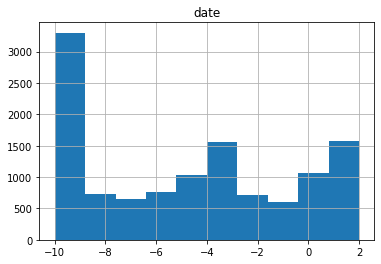

In [ ]:
pass_fail_click_df.hist(column='date')

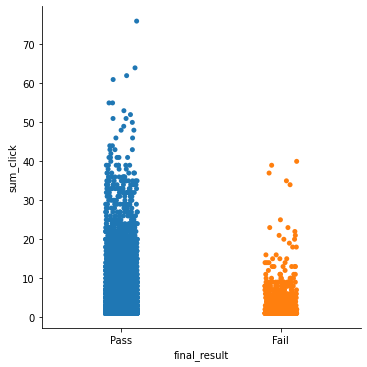

In [ ]:
sns.catplot(x="final_result", y="sum_click", data=pass_fail_click_df, height=5)

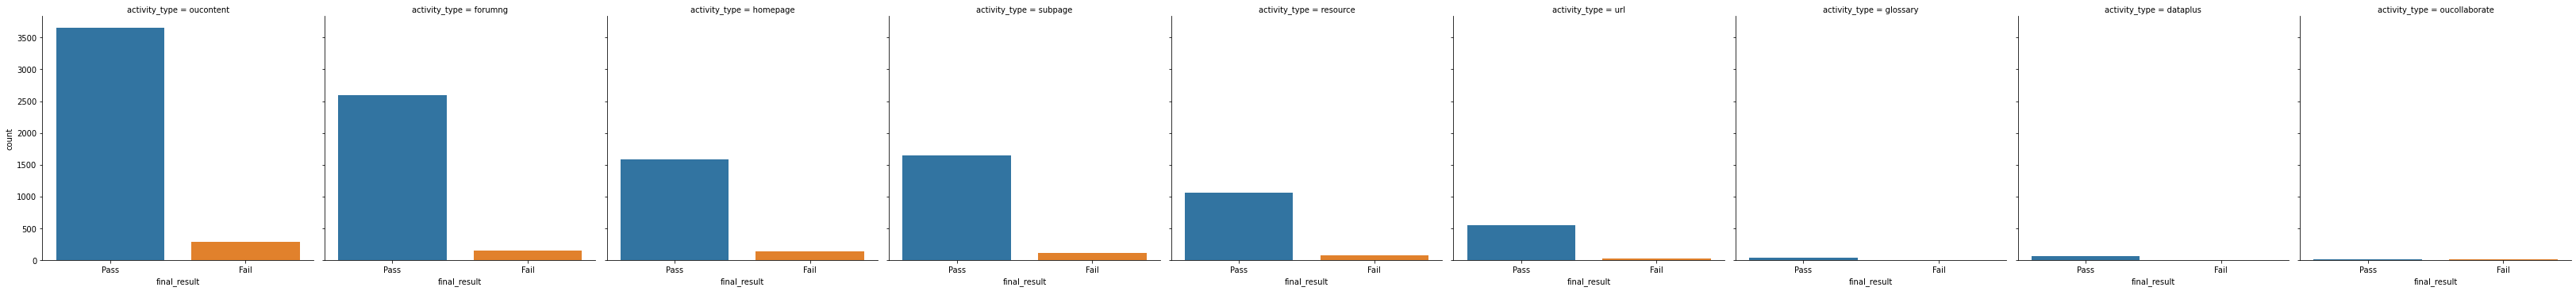

In [ ]:
pass_fail_click_activity_df = pd.merge(pass_fail_click_df, vle, on=['id_site'])
sns.catplot(x="final_result", col="activity_type", data=pass_fail_click_activity_df, kind="count", height=5)

## Predictive Analytics

### Data Preparation and Feature Extraction

In [ ]:
studentAssessment_merged = studentAssessment.merge(assessments, on =['id_assessment'], how='left') # leftjoin assessment x studentAssessment
studentAssessment_merged = studentAssessment_merged[['id_assessment','id_student','score','code_module', 'code_presentation']] # projection

In [ ]:
student_list = []
assesment_list = []
df = studentAssessment_merged.groupby(['id_student','code_module','code_presentation']) # grouping students by module and run

for i,group in df:
    student_list.append(i)
    assesment_list.append(list(group['score']))

In [ ]:
student_total_assessments = pd.DataFrame(assesment_list,student_list)

col = []
for i in range(1, student_total_assessments.shape[1]+1): # creation of table of all assessments for each student
    col.append('assessment_' + str(i))

student_total_assessments.columns = col

student_total_assessments = student_total_assessments.reset_index()
student_total_assessments.rename(columns={'index':'id_student'},inplace=True)
student_total_assessments['id_student'],student_total_assessments['code_module'],student_total_assessments['code_presentation'] = zip(*student_total_assessments.id_student)

In [ ]:
studentData = student_total_assessments.merge(pass_fail_info, on = ['id_student', 'code_module','code_presentation'], how='left')
studentData = studentData.drop(['code_module', 'code_presentation', 'num_of_prev_attempts', 'studied_credits'], axis=1)
studentData = studentData[studentData['final_result'].notna()]
studentData['final_result'] = np.where(studentData['final_result'] == 'Fail', 0, 1)

In [ ]:
to_encode = ['gender', 'region', 'disability']
encoded_StudentData = studentData.copy()

for i in range(0, len(to_encode)):

    column = to_encode[i]
    one_hot_columns = pd.get_dummies(encoded_StudentData[column], prefix=column)
    encoded_StudentData = encoded_StudentData.drop(column, axis=1)
    encoded_StudentData = encoded_StudentData.join(one_hot_columns)


qualification_labels = {
    'No formal quals': 0,
    'Lower Than A Level': 1,
    'A Level or Equivalent': 2,
    'HE Qualification': 3,
    'Post Graudate Qualification': 4
}

imd_labels = {
    '0-10%': 0,
    '10-20': 1,
    '20-30%': 2,
    '30-40%': 3,
    '40-50%': 4,
    '50-60%': 5,
    '60-70%': 6,
    '70-80%': 7,
    '80-90%': 8,
    '90-100%': 9
}

age_labels = {
    '0-35': 0,
    '35-55': 1,
    '55<=': 2
}

encoded_StudentData['highest_education'] = encoded_StudentData['highest_education'].map(qualification_labels)
encoded_StudentData['imd_band'] = encoded_StudentData['imd_band'].map(imd_labels)
encoded_StudentData['age_band'] = encoded_StudentData['age_band'].map(age_labels)

In [ ]:
final_result_column = encoded_StudentData.pop('final_result')
encoded_StudentData['final_result'] = final_result_column
encoded_StudentData = encoded_StudentData.fillna(value=0)
encoded_StudentData

,id_student,assessment_1,assessment_2,assessment_3,assessment_4,assessment_5,assessment_6,assessment_7,assessment_8,assessment_9,assessment_10,assessment_11,assessment_12,assessment_13,assessment_14,highest_education,imd_band,age_band,gender_F,gender_M,region_East Anglian Region,region_East Midlands Region,region_Ireland,region_London Region,region_North Region,region_North Western Region,region_Scotland,region_South East Region,region_South Region,region_South West Region,region_Wales,region_West Midlands Region,region_Yorkshire Region,disability_N,disability_Y,final_result
0,6516,60.0,48.0,63.0,61.0,77.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,2,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1
3,11391,78.0,85.0,80.0,85.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,9.0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,23629,67.0,63.0,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5,23698,94.0,60.0,69.0,67.0,78.0,93.0,73.0,56.0,80.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
6,23798,90.0,90.0,89.0,88.0,87.0,89.0,100.0,100.0,100.0,100.0,100.0,0.0,0.0,0.0,2.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25837,2698251,69.0,76.0,53.0,67.0,62.0,36.0,44.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
25838,2698257,58.0,64.0,76.0,67.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1
25840,2698535,61.0,58.0,62.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1
25841,2698577,100.0,54.0,56.0,58.0,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [50]:
encoded_StudentData = shuffle(encoded_StudentData, random_state=0)
data = encoded_StudentData.drop(['final_result'], axis=1)
labels = encoded_StudentData['final_result'].values

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=0)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16920, 35), (16920,), (4230, 35), (4230,))

In [47]:
X_train['final_result'] = y_train
pass_df = X_train[X_train['final_result'] == 1]
fail_df = X_train[X_train['final_result'] == 0]

fail_upsampled_df = resample(fail_df, n_samples=pass_df.shape[0], random_state=0)
X_train = pd.concat([pass_df, fail_upsampled_df])
y_train = X_train['final_result'].values
X_train = X_train.drop('final_result', axis=1)

### Evaluation

#### Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

#### ROC Curve

In [ ]:
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Display Classification Accuracies over results and plot Confusion Matrix and ROC Curve results

In [ ]:
def display_results(y_pred, y_test):

    # print classification report and plot confusion matrix and ROC curve
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(y_test, y_pred)
    plot_roc_curve(y_test, y_pred)

### Prediction with Machine Learning

#### Random Forest Classifier

In [ ]:
RF_classifier = RandomForestClassifier(random_state=0).fit(X_train, y_train)
y_pred = RF_classifier.predict(X_test)

              precision    recall  f1-score   support

           0       0.85      0.69      0.76      1172
           1       0.89      0.95      0.92      3058

    accuracy                           0.88      4230
   macro avg       0.87      0.82      0.84      4230
weighted avg       0.88      0.88      0.87      4230



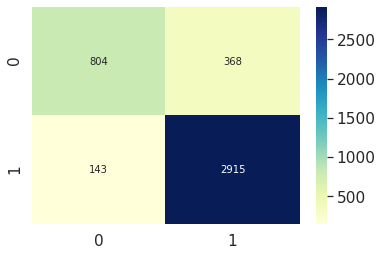

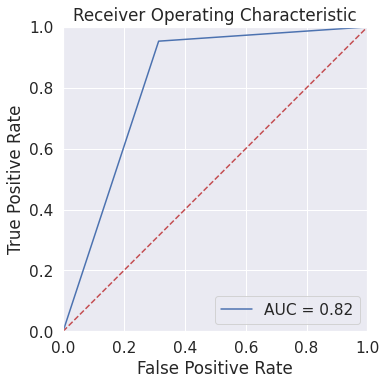

In [ ]:
display_results(y_pred, y_test)

#### Logistic Regression

In [ ]:
LR_model = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = LR_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.63      0.53      0.57      1123
           1       0.84      0.89      0.86      3107

    accuracy                           0.79      4230
   macro avg       0.74      0.71      0.72      4230
weighted avg       0.78      0.79      0.79      4230



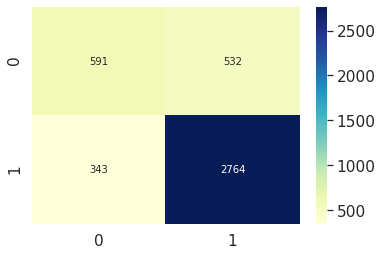

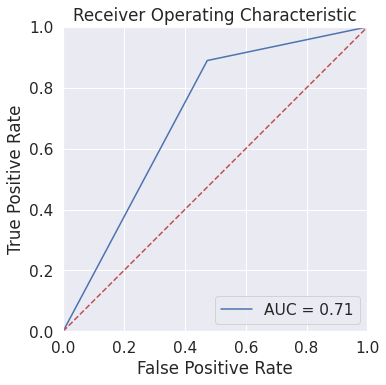

In [ ]:
display_results(y_pred, y_test)

#### Naive Bayes

In [ ]:
NB_model = GaussianNB().fit(X_train, y_train)
y_pred = NB_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.50      0.78      0.61      1172
           1       0.89      0.70      0.79      3058

    accuracy                           0.72      4230
   macro avg       0.70      0.74      0.70      4230
weighted avg       0.78      0.72      0.74      4230



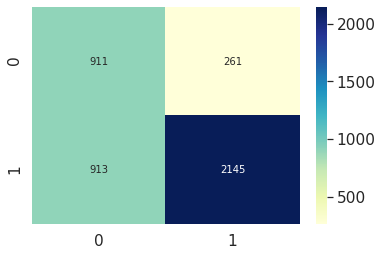

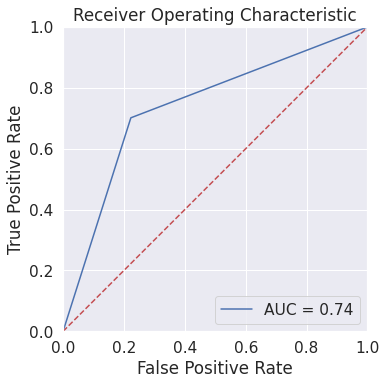

In [ ]:
display_results(y_pred, y_test)

#### Support Vector Machine Model

In [ ]:
SVM_model = SVC(kernel='rbf').fit(X_train, y_train)
y_pred = SVM_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.29      0.46      0.36      1172
           1       0.74      0.57      0.64      3058

    accuracy                           0.54      4230
   macro avg       0.51      0.52      0.50      4230
weighted avg       0.61      0.54      0.57      4230



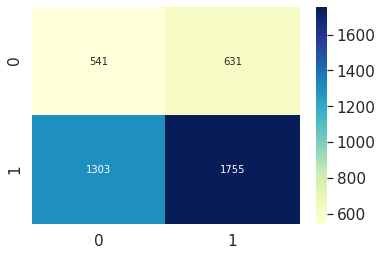

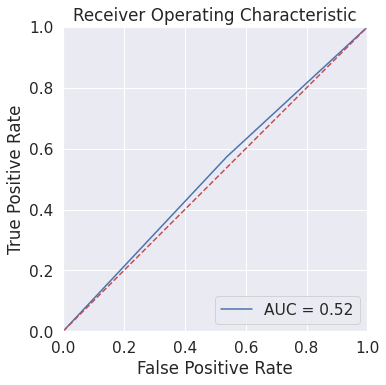

In [ ]:
display_results(y_pred, y_test)

#### Multi-Layer Perceptron

In [38]:
MLP = Sequential()
MLP.add(Dense(512, activation='relu', input_dim=35))
MLP.add(Dense(256, activation='relu'))
MLP.add(Dense(128, activation='relu'))
MLP.add(Dense(64, activation='relu'))
MLP.add(Dense(1, activation='sigmoid'))
MLP.compile(optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy'])
print(MLP.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 512)               18432     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 190,977
Trainable params: 190,977
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
batch_size = 32

fail, pass_rate = np.bincount(encoded_StudentData['final_result'])
total = fail + pass_rate

fail_weight = (1 / fail)*(total)/2.0 
pass_weight = (1 / pass_rate)*(total)/2.0
class_weights = {0: fail_weight, 1: pass_weight}

#model_save_file = main_path + "models/tfidf_MLP.hdf5"
#checkpoint = ModelCheckpoint(model_save_file, monitor='val_loss', verbose=0,
#    save_best_only=True, mode='auto')

MLP.fit(X_train, y_train, batch_size=batch_size,
        epochs=20, validation_data=(X_test, y_test), class_weight=class_weights)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/20
529/529 [==============================] - 4s 5ms/step - loss: 1209.5427 - accuracy: 0.5044 - val_loss: 205.3804 - val_accuracy: 0.2709
Epoch 2/20
529/529 [==============================] - 3s 5ms/step - loss: 92.6358 - accuracy: 0.5232 - val_loss: 0.7003 - val_accuracy: 0.2740
Epoch 3/20
529/529 [==============================] - 3s 5ms/step - loss: 0.7400 - accuracy: 0.2755 - val_loss: 0.6953 - val_accuracy: 0.2716
Epoch 4/20
529/529 [==============================] - 2s 5ms/step - loss: 0.6943 - accuracy: 0.2749 - val_loss: 0.6938 - val_accuracy: 0.2716
Epoch 5/20
529/529 [==============================] - 2s 5ms/step - loss: 0.6939 - accuracy: 0.2970 - val_loss: 0.6953 - val_accuracy: 0.2714
Epoch 6/20
529/529 [==============================] - 3s 5ms/step - loss: 0.6948 - accuracy: 0.2875 - val_loss: 0.6936 - val_accuracy: 0.2702
Epoc

In [68]:
MLP = MLPClassifier(random_state=0, hidden_layer_sizes=(256, 128), max_iter=2000).fit(X_train, y_train)
y_pred = MLP.predict(X_test)

              precision    recall  f1-score   support

           0       0.83      0.59      0.69      1172
           1       0.86      0.95      0.90      3058

    accuracy                           0.85      4230
   macro avg       0.84      0.77      0.80      4230
weighted avg       0.85      0.85      0.84      4230



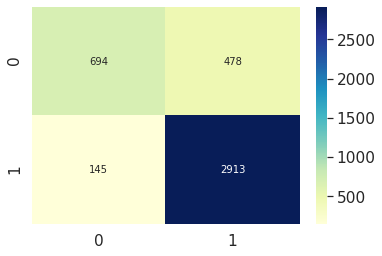

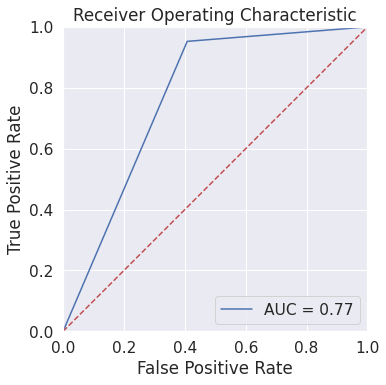

In [66]:
display_results(y_pred, y_test)